In [1]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
data = yf.download("BTC-USD", start="2014-09-15", end="2022-01-18")[['Close']]
data.index = pd.to_datetime(data.index)
data.tail().round(2)

[*********************100%***********************]  1 of 1 completed


,Close
Date,
2022-01-13,42591.57
2022-01-14,43099.70
2022-01-15,43177.40
2022-01-16,43113.88
2022-01-17,42250.55


In [3]:
data

,Close
Date,
2014-09-17,457.334015
2014-09-18,424.440002
2014-09-19,394.795990
2014-09-20,408.903992
2014-09-21,398.821014
...,...
2022-01-13,42591.570312
2022-01-14,43099.699219
2022-01-15,43177.398438


<AxesSubplot:xlabel='Date'>

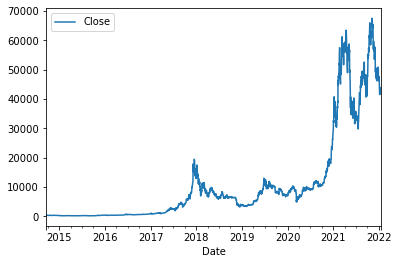

In [4]:
data.plot()

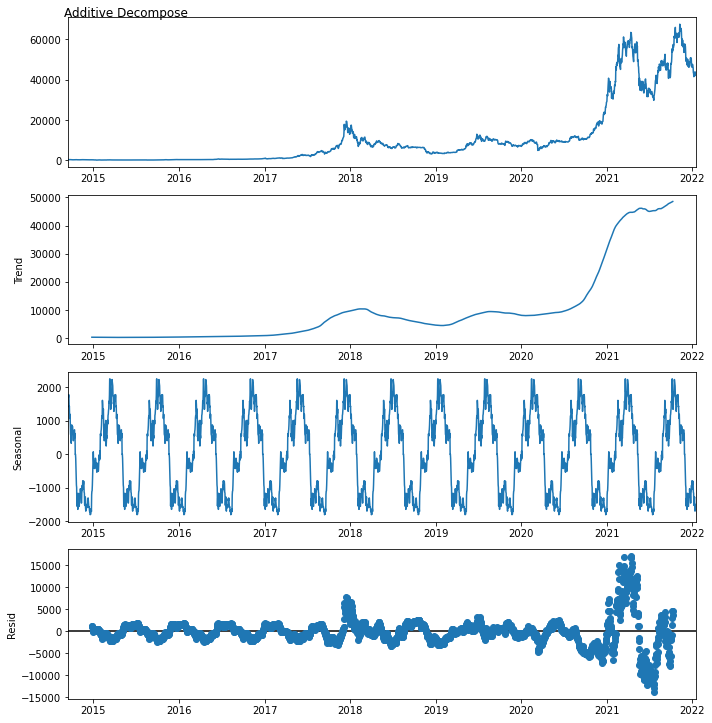

In [5]:
# Decompose (additive) the time series to find any stationarity
from statsmodels.tsa.seasonal import seasonal_decompose

result_add = seasonal_decompose(data, model='additive', period=200)

plt.rcParams.update({'figure.figsize': (10,10)})
result_add.plot().suptitle('Additive Decompose', fontsize=12, x=0.18, y=1)

plt.show()

*There is clear seasonality in the time series.*

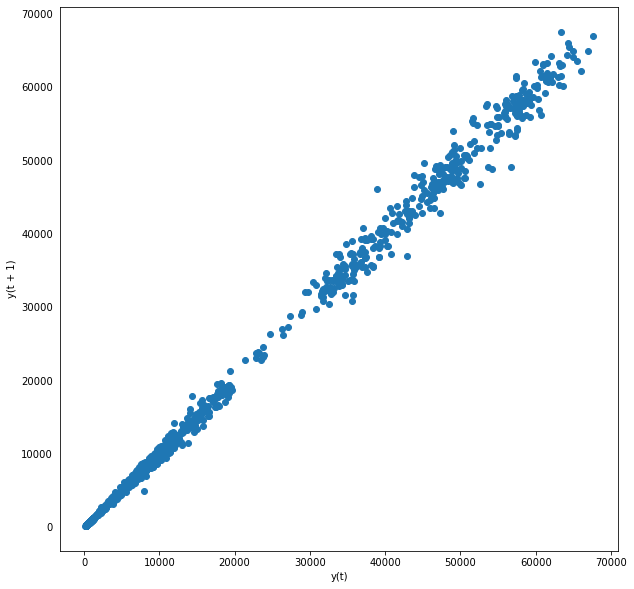

In [6]:
# Ploting lags of my time series
from pandas.plotting import lag_plot

plt.rcParams.update({'ytick.left' : False, 'axes.titlepad':10})

lag_plot(data)
plt.show()

*There is linear autocorrelation for this time series.*

In [7]:
# Import adfuller
from statsmodels.tsa.stattools import adfuller

result = adfuller(data.Close)
print('ADF Test Statistic: %.2f' % result[0])
print('5%% Critical Value: %.2f' % result[4]['5%'])
print('p-value: %.2f' % result[1])

ADF Test Statistic: -1.08
5% Critical Value: -2.86
p-value: 0.72


*The p-value of adf-test is higher than 5%: the time series is not stationary.*

C:\Users\Shinemet\AppData\Local\Temp/ipykernel_14180/2080804263.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Difference'] = data['Close'].diff()


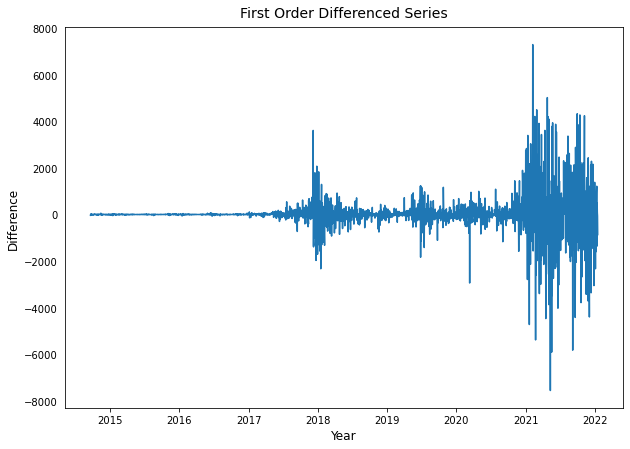

In [8]:
# Let's seasonal difference the series
data['Difference'] = data['Close'].diff()
difference = data.Difference.dropna()

# Plot the Change
plt.figure(figsize=(10, 7))
plt.plot(data['Difference'])
plt.title('First Order Differenced Series', fontsize=14)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Difference', fontsize=12)
plt.show()

In [9]:
# Drop first and last differences calculated
result = adfuller(difference)
print(result)
print('ADF Test Statistic: %.2f' % result[0])
print('5%% Critical Value: %.2f' % result[4]['5%'])
print('p-value: %.2f' % result[1])

(-8.3843892534455, 2.4607674691722916e-13, 28, 2650, {'1%': -3.43282005496258, '5%': -2.862631284316046, '10%': -2.5673509283018867}, 42613.02921620262)
ADF Test Statistic: -8.38
5% Critical Value: -2.86
p-value: 0.00


*ADF-test's p-value on the difference is lower than 5%: the time series is now stationary.*

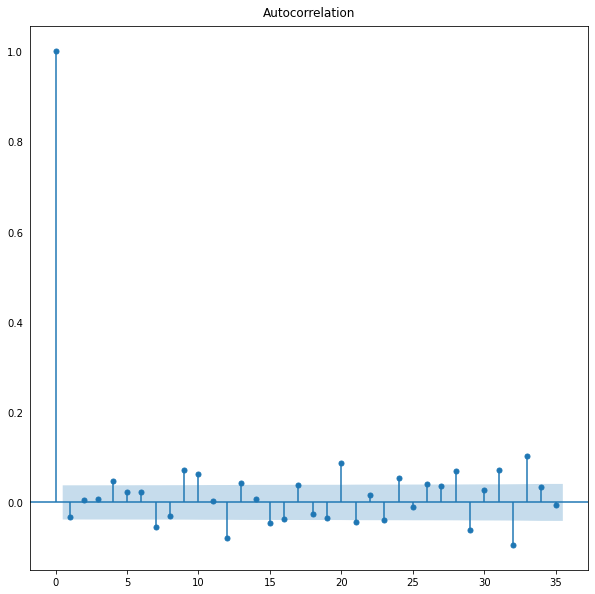

In [10]:
# Plotting acf on dataset after removing NaN values
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(difference)
plt.show()

In [11]:
# Splitting the dataset in test and train with a 30/70 ratio:
from sklearn.model_selection import train_test_split

train, test = train_test_split(difference, test_size=.33, shuffle=False)
test

Date
2019-08-17    -142.594727
2019-08-18     114.066406
2019-08-19     570.243164
2019-08-20    -152.821289
2019-08-21    -625.182617
                 ...     
2022-01-13   -1357.531250
2022-01-14     508.128906
2022-01-15      77.699219
2022-01-16     -63.519531
2022-01-17    -863.328125
Name: Difference, Length: 885, dtype: float64

In [12]:
# Build Autoregression model on train:
from statsmodels.tsa.ar_model import AutoReg

AR_model = AutoReg(train, lags=20)
AR_model_fit = AR_model.fit()
print('Coefficients: %s' % AR_model_fit.params)

Coefficients: intercept         4.596989
Difference.L1     0.027748
Difference.L2    -0.035682
Difference.L3     0.024379
Difference.L4    -0.032710
Difference.L5     0.119856
Difference.L6    -0.037397
Difference.L7    -0.029836
Difference.L8     0.031458
Difference.L9     0.010154
Difference.L10    0.125734
Difference.L11    0.009416
Difference.L12   -0.018094
Difference.L13   -0.088201
Difference.L14   -0.036121
Difference.L15   -0.056420
Difference.L16   -0.060905
Difference.L17    0.058542
Difference.L18   -0.012917
Difference.L19    0.097206
Difference.L20    0.089669
dtype: float64


C:\Users\Shinemet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\Shinemet\anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


In [13]:
predictions = AR_model_fit.predict(start=test.index[0], end=test.index[-1])
predictions

C:\Users\Shinemet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)
C:\Users\Shinemet\anaconda3\lib\site-packages\statsmodels\tsa\deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


2019-08-17      1.914640
2019-08-18   -111.100390
2019-08-19    -76.168102
2019-08-20     17.947745
2019-08-21     22.823397
                 ...    
2022-01-13      5.646556
2022-01-14      5.646556
2022-01-15      5.646556
2022-01-16      5.646556
2022-01-17      5.646556
Freq: D, Length: 885, dtype: float64

In [14]:
AR_model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            AutoReg Model Results                             
==============================================================================
Dep. Variable:             Difference   No. Observations:                 1794
Model:                    AutoReg(20)   Log Likelihood              -12455.048
Method:               Conditional MLE   S.D. of innovations            270.953
Date:                Wed, 19 Jan 2022   AIC                             11.229
Time:                        16:24:19   BIC                             11.297
Sample:                    10-08-2014   HQIC                            11.254
                         - 08-16-2019                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
intercept          4.5970      6.459      0.712      0.477      -8.062      17.256
Difference.L1      0.0277      0.024      1.173      0.241      -0.019       0.074
Difference.L2     -0.0357      0.024     -1.515      0.130      -0.082       0.010
Difference.L3      0.0244      0.024      1.032      0.302      -0.022       0.071
Difference.L4     -0.0327      0.024     -1.385      0.166      -0.079       0.014
Difference.L5      0.1199      0.024      5.081      0.000       0.074       0.166
Difference.L6     -0.0374      0.024     -1.576      0.115      -0.084       0.009
Difference.L7     -0.0298      0.024     -1.255      0.210      -0.076       0.017
Difference.L8      0.0315      0.024      1.327      0.185      -0.015       0.078
Difference.L9      0.0102      0.024      0.428      0.669      -0.036       0.057
Difference.L10     0.1257      0.024      5.297      0.000       0.079       0.172
Difference.L11     0.0094      0.024      0.396      0.692      -0.037       0.056
Difference.L12    -0.0181      0.024     -0.760      0.447      -0.065       0.029
Difference.L13    -0.0882      0.024     -3.704      0.000      -0.135      -0.042
Difference.L14    -0.0361      0.024     -1.511      0.131      -0.083       0.011
Difference.L15    -0.0564      0.024     -2.360      0.018      -0.103      -0.010
Difference.L16    -0.0609      0.024     -2.562      0.010      -0.107      -0.014
Difference.L17     0.0585      0.024      2.459      0.014       0.012       0.105
Difference.L18    -0.0129      0.024     -0.542      0.588      -0.060       0.034
Difference.L19     0.0972      0.024      4.081      0.000       0.051       0.144
Difference.L20     0.0897      0.024      3.748      0.000       0.043       0.137
                                    Roots                                     
==============================================================================
                   Real          Imaginary           Modulus         Frequency
------------------------------------------------------------------------------
AR.1             1.1066           -0.0000j            1.1066           -0.0000
AR.2             1.0502           -0.3087j            1.0946           -0.0455
AR.3             1.0502           +0.3087j            1.0946            0.0455
AR.4             0.8357           -0.6398j            1.0525           -0.1040
AR.5             0.8357           +0.6398j            1.0525            0.1040
AR.6             0.6091           -0.9551j            1.1328           -0.1596
AR.7             0.6091           +0.9551j            1.1328            0.1596
AR.8             0.3086           -1.0439j            1.0886           -0.2043
AR.9             0.3086           +1.0439j            1.0886            0.2043
AR.10           -0.0250           -1.1466j            1.1469           -0.2535
AR.11           -0.0250           +1.1466j            1.1469            0.2535
AR.12           -0.3518           -1.0647j            1.1213    

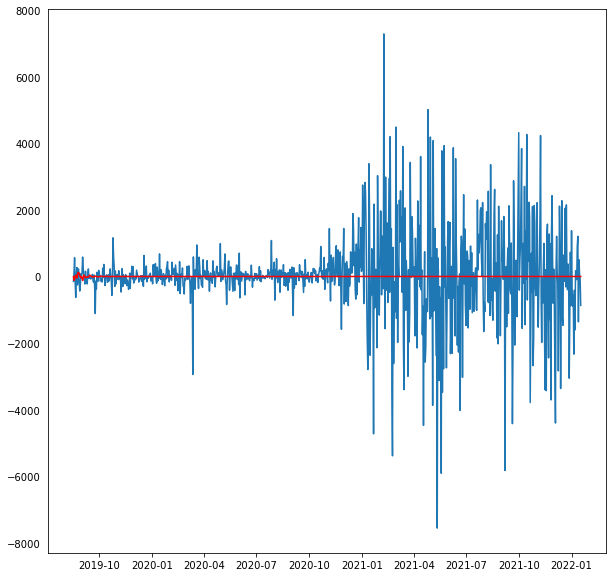

In [15]:
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()

In [20]:
# Building ARMA model on my dataset:
from statsmodels.tsa.arima_model import ARMA

train_model_fit = ARMA(train, order=(1, 1)).fit()
train_model_fit.summary()

C:\Users\Shinemet\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
C:\Users\Shinemet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:             Difference   No. Observations:                 1794
Model:                     ARMA(1, 1)   Log Likelihood              -12655.095
Method:                       css-mle   S.D. of innovations            280.109
Date:                Wed, 19 Jan 2022   AIC                          25318.190
Time:                        16:25:32   BIC                          25340.159
Sample:                    09-18-2014   HQIC                         25326.301
                         - 08-16-2019                                         
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const                5.5119      6.815      0.809      0.419      -7.845      18.869
ar.L1.Difference    -0.7402      0.081     -9.182      0.000      -0.898      -0.582
ma.L1.Difference     0.7932      0.072     10.979      0.000       0.652       0.935
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.3511           +0.0000j            1.3511            0.5000
MA.1           -1.2607           +0.0000j            1.2607            0.5000
-----------------------------------------------------------------------------
"""

In [21]:
from statsmodels.tools.eval_measures import rmse

rmse(predictions, test)

1263.521075353767